In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY=os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT=os.getenv("LANGSMITH_PROJECT")
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

f:\dev25\Building-Agentic-AI\Langgraph_Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

In [4]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [5]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

In [6]:
tavily_tool = TavilySearchResults(max_results=5)
# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()

In [7]:
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [8]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_openai import ChatOpenAI

In [9]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [10]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [11]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [12]:
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)

In [ ]:
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [14]:
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)

In [ ]:
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [16]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [17]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [18]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

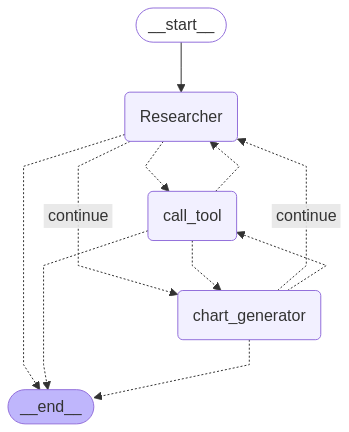

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the Japan's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_8460\2036866128.py:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Qp4agUgrwe2dwQ5NHFm27Xyq', 'function': {'arguments': '{"query":"Japan GDP historical data past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 218, 'total_tokens': 244, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BQdxSV7atmw8BOR21Izvg6ZitOeTS', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-9b80b3f4-f10c-4cdd-9c7a-e9049b487442-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Japan GDP historical data past 5 years'}, 'id': 'call_Qp4agUgrwe2dwQ5NHFm27Xyq', 'type': 'to

C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_8460\2036866128.py:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eEMvw7WgndK61cfkfkAtYFbs', 'function': {'arguments': '{"query": "Japan GDP 2022 2021 2020 2019 2018 in billion USD"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_hb8dMzoxbKiOqR49KZktMeCF', 'function': {'arguments': '{"query": "Japan GDP 2023 current data"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 2289, 'total_tokens': 2367, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BQdxZn4JIWbVt3Wn5IoBftRJCUESB', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-adc775b6-974d-4628-

C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_8460\2036866128.py:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ulSloKZmGIcNt7NWUlL8jzvX', 'function': {'arguments': '{"query":"Japan GDP 2022 2021 2020 2019 2018 in million USD"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 5773, 'total_tokens': 5811, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2176}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BQdxgilUtlHFp2LYddwvSzkiV2jMf', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-c89bab4e-cec7-4ad3-97c0-9a89680d7450-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Japan GDP 2022 2021 2020 2019 2018 in million USD'}, 'id': 'call_ulSloKZmGIc

C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_8460\2036866128.py:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [21]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
<>:24: SyntaxWarning: invalid escape sequence '\`'
C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_8460\1267643975.py:24: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_8460\1267643975.py:24: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [22]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [24]:
from typing import Literal
from langchain_openai import ChatOpenAI

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


#llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm = ChatOpenAI(model="gpt-4o-mini")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [25]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

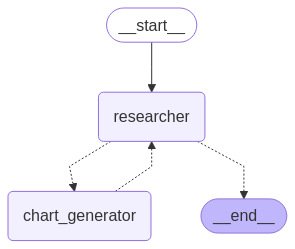

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the Japan's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="First, get the Japan's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='d99ed875-7442-4ea4-820d-db2a252166e1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BxifgZkpvnjheqqfpFktI9R3', 'function': {'arguments': '{"query":"Japan GDP data for past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 209, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BQe02ITidvBRTDrPStxiimvKhlJxE', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2017

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [HumanMessage(content="First, get the Japan's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='d99ed875-7442-4ea4-820d-db2a252166e1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BxifgZkpvnjheqqfpFktI9R3', 'function': {'arguments': '{"query":"Japan GDP data for past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 209, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BQe02ITidvBRTDrPStxiimvKhlJxE', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run